In [1]:
%load_ext autoreload
%autoreload 2

# 06-Transfer-Learning-Part3-Food-Vision-Mini

### Some imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.image import ClassicImageDataDirectory, ImageDataset

import os

## 101 Food Classes - Working with less data (`10 percent`)

In [3]:
IMAGE_DIM = (224, 224)

### Load the data

In [4]:
data_dir = '../data/101_food_classes_10_percent/'
imgdir = ClassicImageDataDirectory(data_dir, target_image_size=IMAGE_DIM, dtype=np.uint8)
imgdir

### Explore the data

In [5]:
imgdir.class_names

('apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [6]:
imgdir.labelcountdf

label            name  count_train  count_test
0        0       apple_pie           75         250
1        1  baby_back_ribs           75         250
2        2         baklava           75         250
3        3  beef_carpaccio           75         250
4        4    beef_tartare           75         250
..     ...             ...          ...         ...
96      96           tacos           75         250
97      97        takoyaki           75         250
98      98        tiramisu           75         250
99      99    tuna_tartare           75         250
100    100         waffles           75         250

[101 rows x 4 columns]

### View Example Images

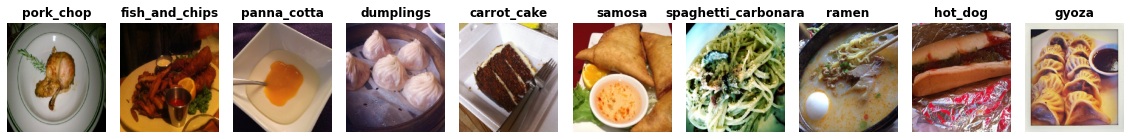

In [7]:
batch = imgdir.load(512)
imgen = next(batch)
imgen.view_random_images(class_names=list(np.random.choice(imgen.class_names, size=10, replace=False)));

## Experiments

* `exp_1`: `efficientnetb0_fine_tune_10_percent`
* `exp_2`: `resnet50v2_fine_tune_10_percent`

#### Hold the experiments

In [114]:
experiments = {}

In [115]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers.experimental.preprocessing as KerasPreprocessing
import tensorflow as tf
from tensorflow.keras import layers, losses, callbacks, optimizers
from src.evaluate import KerasMetrics

from pathlib import Path

In [116]:
from src.image import ImageClassificationExperiment

In [117]:
TFHUB_LOGDIR = str(Path(os.path.abspath('../tensorboard_logs/101_food_multiclass_classification')))

## `exp_1`: `efficientnetb0_fine_tune_10_percent`


In [132]:
exp = ImageClassificationExperiment(name='efficientnetb0_fine_tune_10_percent', 
                                    tfhub_log_dir=TFHUB_LOGDIR)

In [133]:
exp.preprocess_data(scale=False)

In [134]:
exp.setup_directories('../data/101_food_classes_10_percent/')

In [135]:
exp.import_data_from_directories()

Found 6060 images belonging to 101 classes.
Found 1515 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [136]:
exp.create_model(pretrained_model=tf.keras.applications.EfficientNetB0(include_top=False), downstream_model=None)

In [137]:
exp.compile_model()

In [138]:
exp.model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_11 (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
downstream_model (Sequential (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


#### Train in `feature_extraction` mode for 5 epochs

In [139]:
exp.run(5, tfhub_log=True)

Saving TensorBoard log files to " C:\Users\bhati\Google Drive\projects\Tensorflow-tutorial-Daniel-Bourke\tensorboard_logs\101_food_multiclass_classification\efficientnetb0_fine_tune_10_percent\feature_extraction\20210605-141956"
Epoch 1/5
190/190 [==============================] - 81s 392ms/step - loss: 4.1402 - f1: 0.0034 - accuracy: 0.1222 - val_loss: 2.8358 - val_f1: 0.0861 - val_accuracy: 0.3525
Epoch 2/5
190/190 [==============================] - 66s 345ms/step - loss: 2.6281 - f1: 0.1078 - accuracy: 0.4233 - val_loss: 2.3871 - val_f1: 0.2165 - val_accuracy: 0.4277
Epoch 3/5
190/190 [==============================] - 65s 341ms/step - loss: 2.1849 - f1: 0.2431 - accuracy: 0.4957 - val_loss: 2.2139 - val_f1: 0.3197 - val_accuracy: 0.4521
Epoch 4/5
190/190 [==============================] - 67s 350ms/step - loss: 1.8822 - f1: 0.3489 - accuracy: 0.5575 - val_loss: 2.1186 - val_f1: 0.3495 - val_accuracy: 0.4686
Epoch 5/5
190/190 [==============================] - 73s 381ms/step - loss:

#### Train in `fine_tuning` mode for another 5 with last `10` layers unfreezed

In [140]:
exp.set_training_mode('fine_tuning')
exp.compile_model(learning_rate=0.0001) # lower the learning rate by 1/10th for fine tuning
exp.run(5, tfhub_log=True)

Saving TensorBoard log files to " C:\Users\bhati\Google Drive\projects\Tensorflow-tutorial-Daniel-Bourke\tensorboard_logs\101_food_multiclass_classification\efficientnetb0_fine_tune_10_percent\fine_tuning\20210605-142806"
Epoch 5/9
190/190 [==============================] - 104s 509ms/step - loss: 1.6857 - f1: 0.4295 - accuracy: 0.5943 - val_loss: 2.0144 - val_f1: 0.4419 - val_accuracy: 0.4865
Epoch 6/9
190/190 [==============================] - 81s 427ms/step - loss: 1.4924 - f1: 0.5119 - accuracy: 0.6456 - val_loss: 1.9807 - val_f1: 0.4578 - val_accuracy: 0.5030
Epoch 7/9
190/190 [==============================] - 69s 361ms/step - loss: 1.3978 - f1: 0.5517 - accuracy: 0.6653 - val_loss: 1.9626 - val_f1: 0.4754 - val_accuracy: 0.5076
Epoch 8/9
190/190 [==============================] - 68s 359ms/step - loss: 1.3178 - f1: 0.5747 - accuracy: 0.6802 - val_loss: 1.9427 - val_f1: 0.4843 - val_accuracy: 0.5135
Epoch 9/9
190/190 [==============================] - 68s 359ms/step - loss: 1.240

In [141]:
experiments[exp.name] = exp

### Learning Curve

<AxesSubplot:xlabel='epoch', ylabel='loss'>

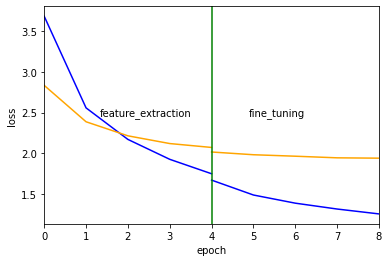

In [167]:
exp.plot_learning_curve()

There is a bit of overfitting evident

## `exp_2`: `resnet50v2_fine_tune_10_percent`

In [156]:
exp = ImageClassificationExperiment(name='resnet50v2_fine_tune_10_percent', tfhub_log_dir=TFHUB_LOGDIR)

In [157]:
exp.preprocess_data(scale=True, data_augment=True)

In [158]:
exp.setup_directories('../data/101_food_classes_10_percent')

In [159]:
exp.import_data_from_directories()

Found 6060 images belonging to 101 classes.
Found 1515 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [160]:
exp.create_model(pretrained_model=tf.keras.applications.ResNet50V2(include_top=False), downstream_model=None)

In [161]:
exp.compile_model()

In [162]:
exp.model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_14 (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_25 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, None, None, 2048)  23564800  
_________________________________________________________________
downstream_model (Sequential (None, 2048)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               206949    
Total params: 23,771,749
Trainable params: 206,949
Non-trainable params: 23,564,800
________________________________________

#### Train in `feature_extraction` mode for 5 epochs

In [163]:
exp.run(5, tfhub_log=True)

Saving TensorBoard log files to " C:\Users\bhati\Google Drive\projects\Tensorflow-tutorial-Daniel-Bourke\tensorboard_logs\101_food_multiclass_classification\resnet50v2_fine_tune_10_percent\feature_extraction\20210605-165835"
Epoch 1/5
190/190 [==============================] - 92s 453ms/step - loss: 4.3019 - f1: 0.0326 - accuracy: 0.1053 - val_loss: 2.8973 - val_f1: 0.1894 - val_accuracy: 0.3109
Epoch 2/5
190/190 [==============================] - 82s 430ms/step - loss: 2.5502 - f1: 0.2355 - accuracy: 0.3742 - val_loss: 2.7016 - val_f1: 0.2865 - val_accuracy: 0.3518
Epoch 3/5
190/190 [==============================] - 81s 427ms/step - loss: 2.1236 - f1: 0.3611 - accuracy: 0.4623 - val_loss: 2.6255 - val_f1: 0.3224 - val_accuracy: 0.3657
Epoch 4/5
190/190 [==============================] - 81s 426ms/step - loss: 1.8732 - f1: 0.4167 - accuracy: 0.5151 - val_loss: 2.5689 - val_f1: 0.3488 - val_accuracy: 0.3809
Epoch 5/5
190/190 [==============================] - 83s 437ms/step - loss: 1.6

#### Train in `fine_tuning` mode for 5 epochs

In [164]:
exp.set_training_mode('fine_tuning')
exp.compile_model(learning_rate=0.0001) # lower the learning rate by 1/10th for fine tuning
exp.run(5, tfhub_log=True)

Saving TensorBoard log files to " C:\Users\bhati\Google Drive\projects\Tensorflow-tutorial-Daniel-Bourke\tensorboard_logs\101_food_multiclass_classification\resnet50v2_fine_tune_10_percent\fine_tuning\20210605-170815"
Epoch 5/9
190/190 [==============================] - 95s 477ms/step - loss: 1.8742 - f1: 0.4006 - accuracy: 0.5531 - val_loss: 2.6160 - val_f1: 0.3779 - val_accuracy: 0.4000
Epoch 6/9
190/190 [==============================] - 88s 465ms/step - loss: 1.4330 - f1: 0.5268 - accuracy: 0.6485 - val_loss: 2.5657 - val_f1: 0.3898 - val_accuracy: 0.4033
Epoch 7/9
190/190 [==============================] - 88s 464ms/step - loss: 1.2824 - f1: 0.5850 - accuracy: 0.6838 - val_loss: 2.5497 - val_f1: 0.3793 - val_accuracy: 0.4040
Epoch 8/9
190/190 [==============================] - 89s 471ms/step - loss: 1.1623 - f1: 0.6342 - accuracy: 0.7247 - val_loss: 2.5472 - val_f1: 0.4140 - val_accuracy: 0.4132
Epoch 9/9
190/190 [==============================] - 88s 465ms/step - loss: 1.0840 - f

### Learning Curve

<AxesSubplot:xlabel='epoch', ylabel='loss'>

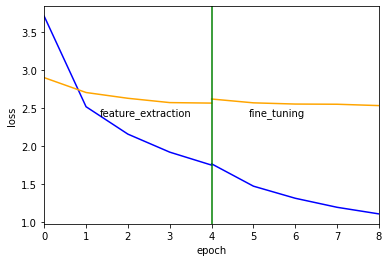

In [169]:
exp.plot_learning_curve()

Much more overfitting than EfficientNetB0

In [165]:
experiments[exp.name] = exp

In both the cases, `feature_extraction` already works well, and so the improvements with `fine_tuning` are not as great. This is probably because both the pretrained models were trained on a similar image classification task which contained some classes of food as well. 

## Compare the performance of the models

In [186]:
from src.evaluate import ClassificationPerformanceComparer

In [187]:
models = {exp.name: exp.model for exp in experiments.values()}

In [188]:
clf_comp = ClassificationPerformanceComparer(models, exp.test_data)

In [189]:
clf_comp.calculate_metric_comparison_df()

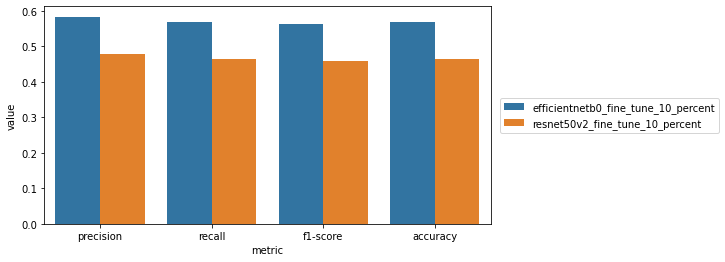

In [190]:
clf_comp.plot_metric_comparison_df()

EfficientNetB0 consistently outperforms ResNet50V2

### Confusion Matrix

In [191]:
from src.visualize import plot_confusion_matrix

#### `exp_1`

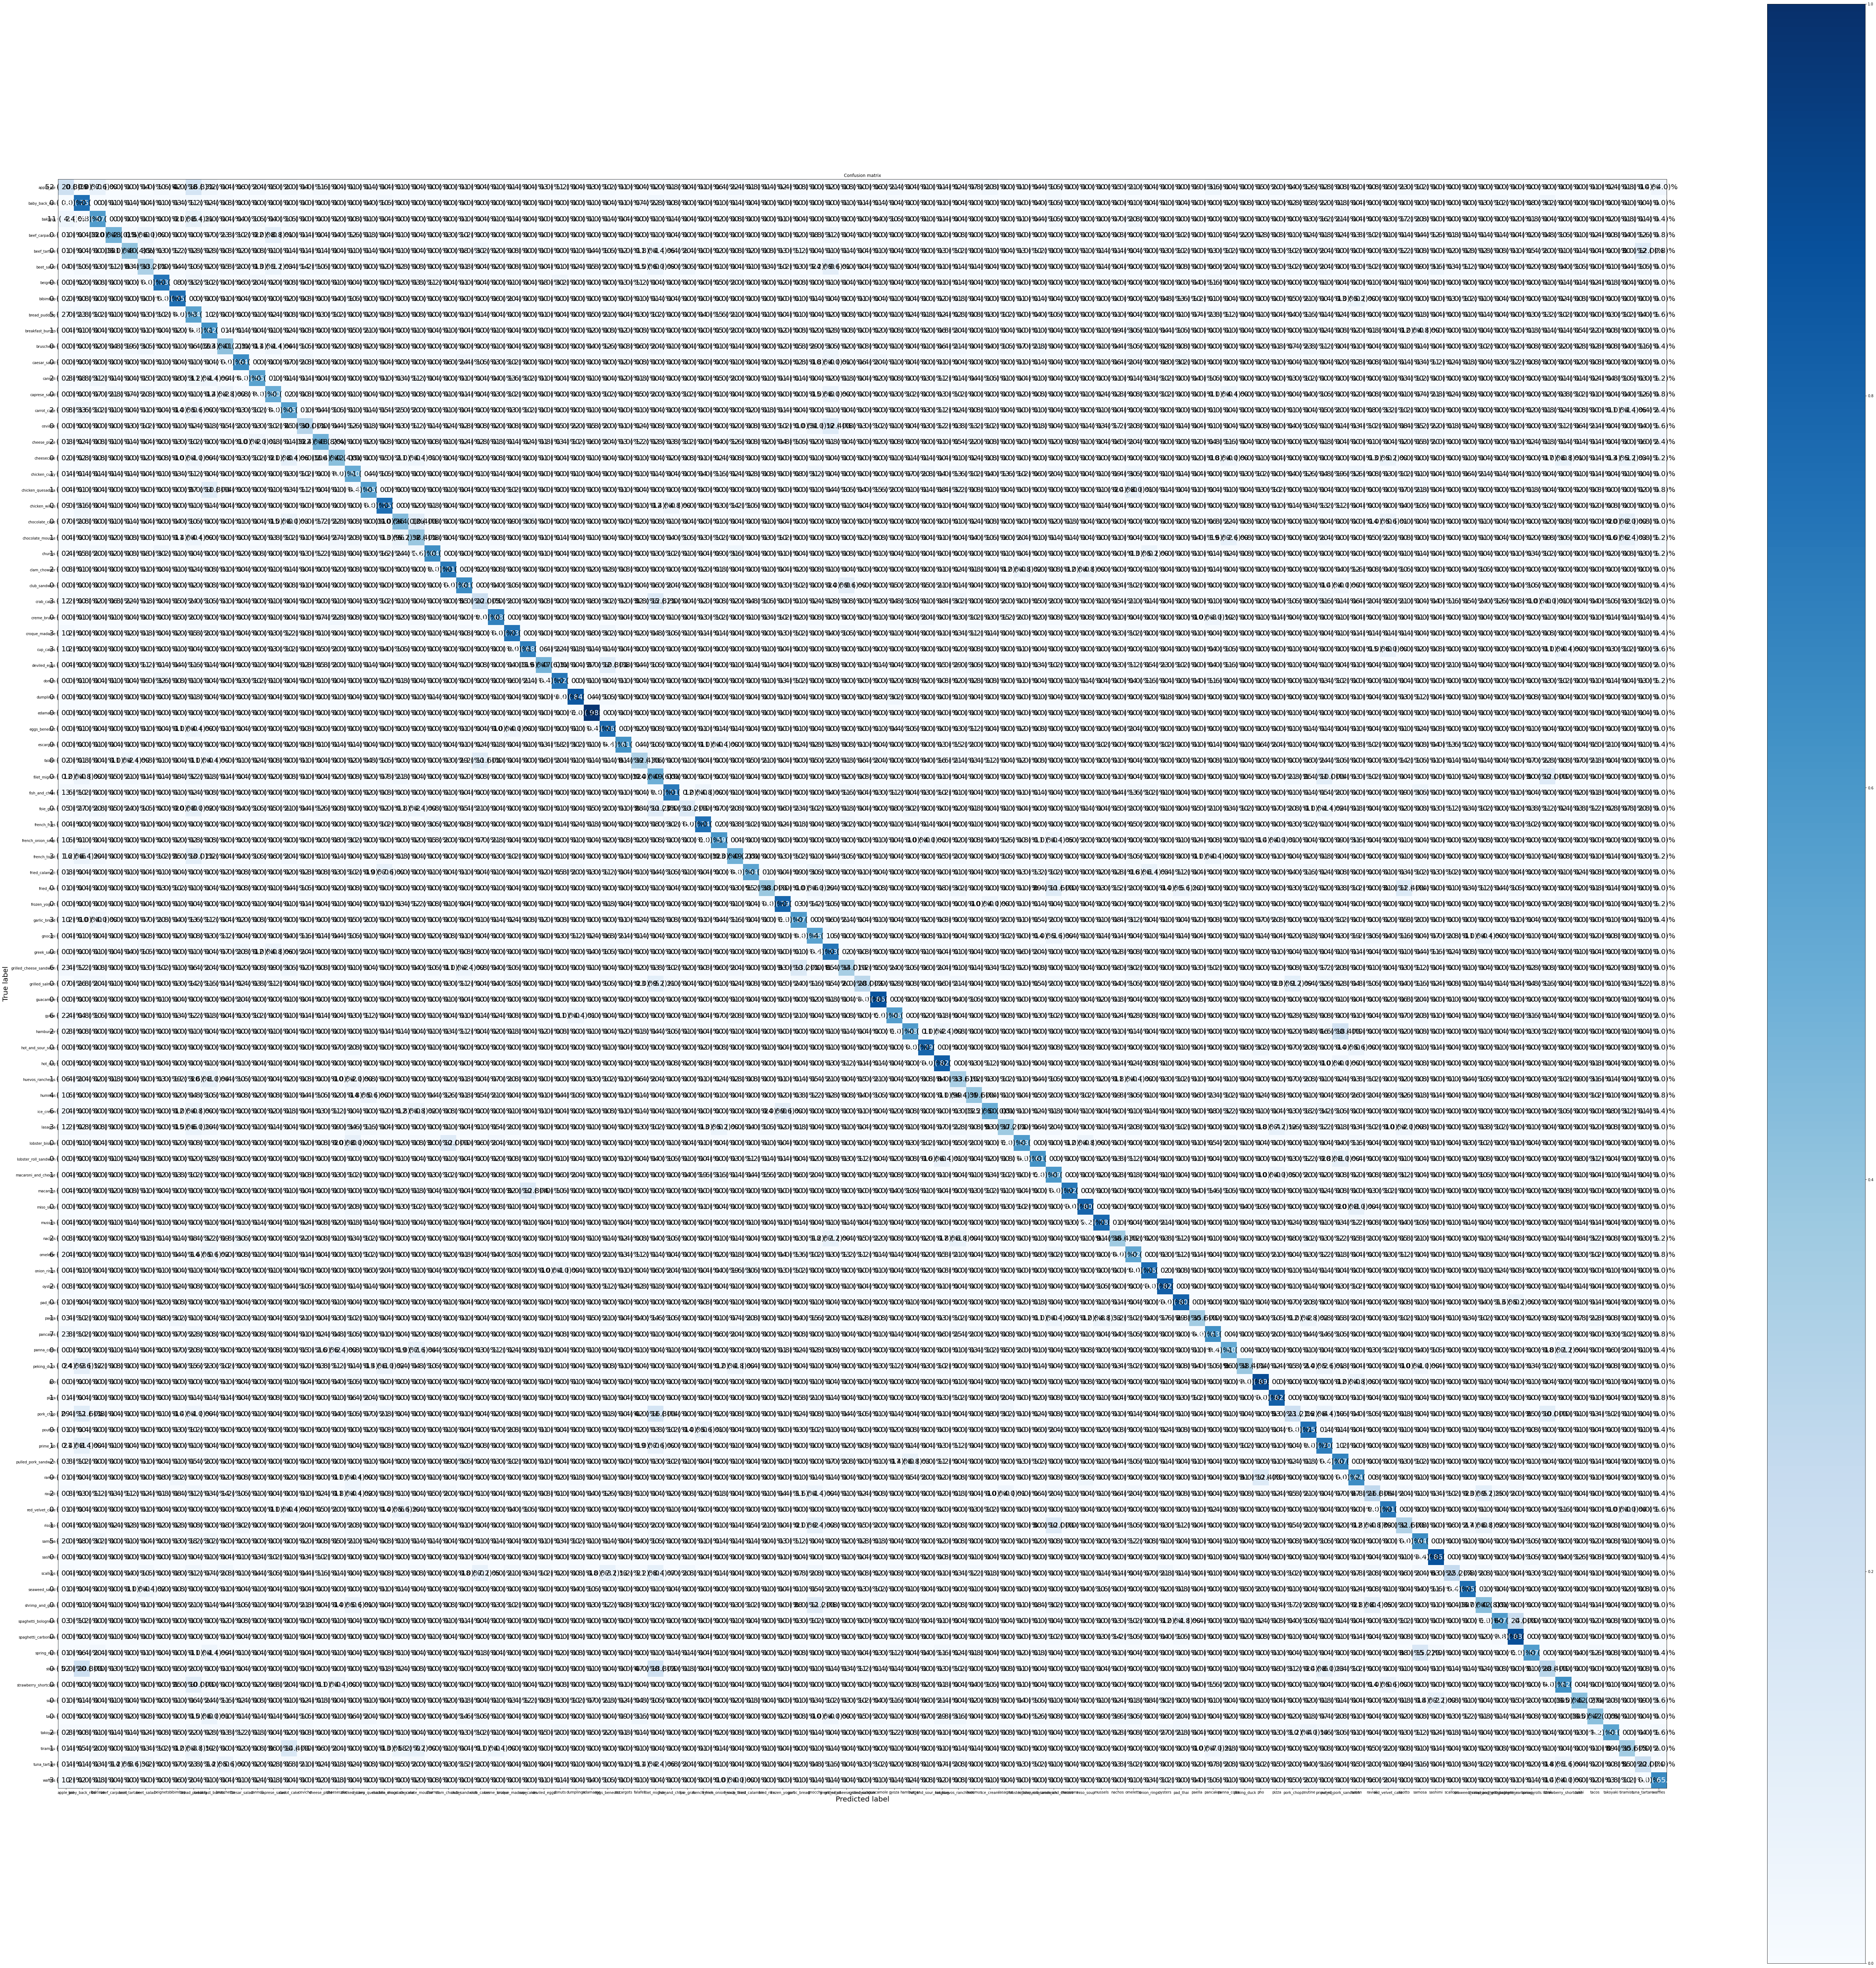

In [193]:
cax = plot_confusion_matrix(clf_comp.data.labels, clf_comp.predictions['efficientnetb0_fine_tune_10_percent'], classes=clf_comp.data.class_indices,
                      figsize=(100, 100), text_size=20)

### Class wise performance comparison (F1-score)

In [200]:
import seaborn as sns

In [196]:
compdf = clf_comp.compdf

compdf.loc[compdf['metric'] == 'f1-score']

metric  apple_pie  baby_back_ribs   baklava  beef_carpaccio  \
2  f1-score   0.241299        0.535613  0.552783           0.600   
6  f1-score   0.139276        0.437659  0.521905           0.375   

   beef_tartare  beet_salad  beignets  bibimbap  bread_pudding  ...     sushi  \
2      0.463303    0.378132   0.73200  0.765784       0.343789  ...  0.531646   
6      0.280788    0.321555   0.67509  0.680653       0.223702  ...  0.339080   

      tacos  takoyaki  tiramisu  tuna_tartare   waffles  accuracy  macro avg  \
2  0.456522  0.586724  0.381974      0.282776  0.601835  0.568079   0.563401   
6  0.211957  0.468193  0.318658      0.205231  0.588469  0.463683   0.459045   

   weighted avg                                model  
2      0.563401  efficientnetb0_fine_tune_10_percent  
6      0.459045      resnet50v2_fine_tune_10_percent  

[2 rows x 106 columns]

In [210]:
compdf_melt = compdf.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1).melt(id_vars=['metric', 'model'])
compdf_melt

metric                                model   variable       value
0    precision  efficientnetb0_fine_tune_10_percent  apple_pie    0.287293
1       recall  efficientnetb0_fine_tune_10_percent  apple_pie    0.208000
2     f1-score  efficientnetb0_fine_tune_10_percent  apple_pie    0.241299
3      support  efficientnetb0_fine_tune_10_percent  apple_pie  250.000000
4    precision      resnet50v2_fine_tune_10_percent  apple_pie    0.229358
..         ...                                  ...        ...         ...
803    support  efficientnetb0_fine_tune_10_percent    waffles  250.000000
804  precision      resnet50v2_fine_tune_10_percent    waffles    0.584980
805     recall      resnet50v2_fine_tune_10_percent    waffles    0.592000
806   f1-score      resnet50v2_fine_tune_10_percent    waffles    0.588469
807    support      resnet50v2_fine_tune_10_percent    waffles  250.000000

[808 rows x 4 columns]

<AxesSubplot:xlabel='value', ylabel='variable'>

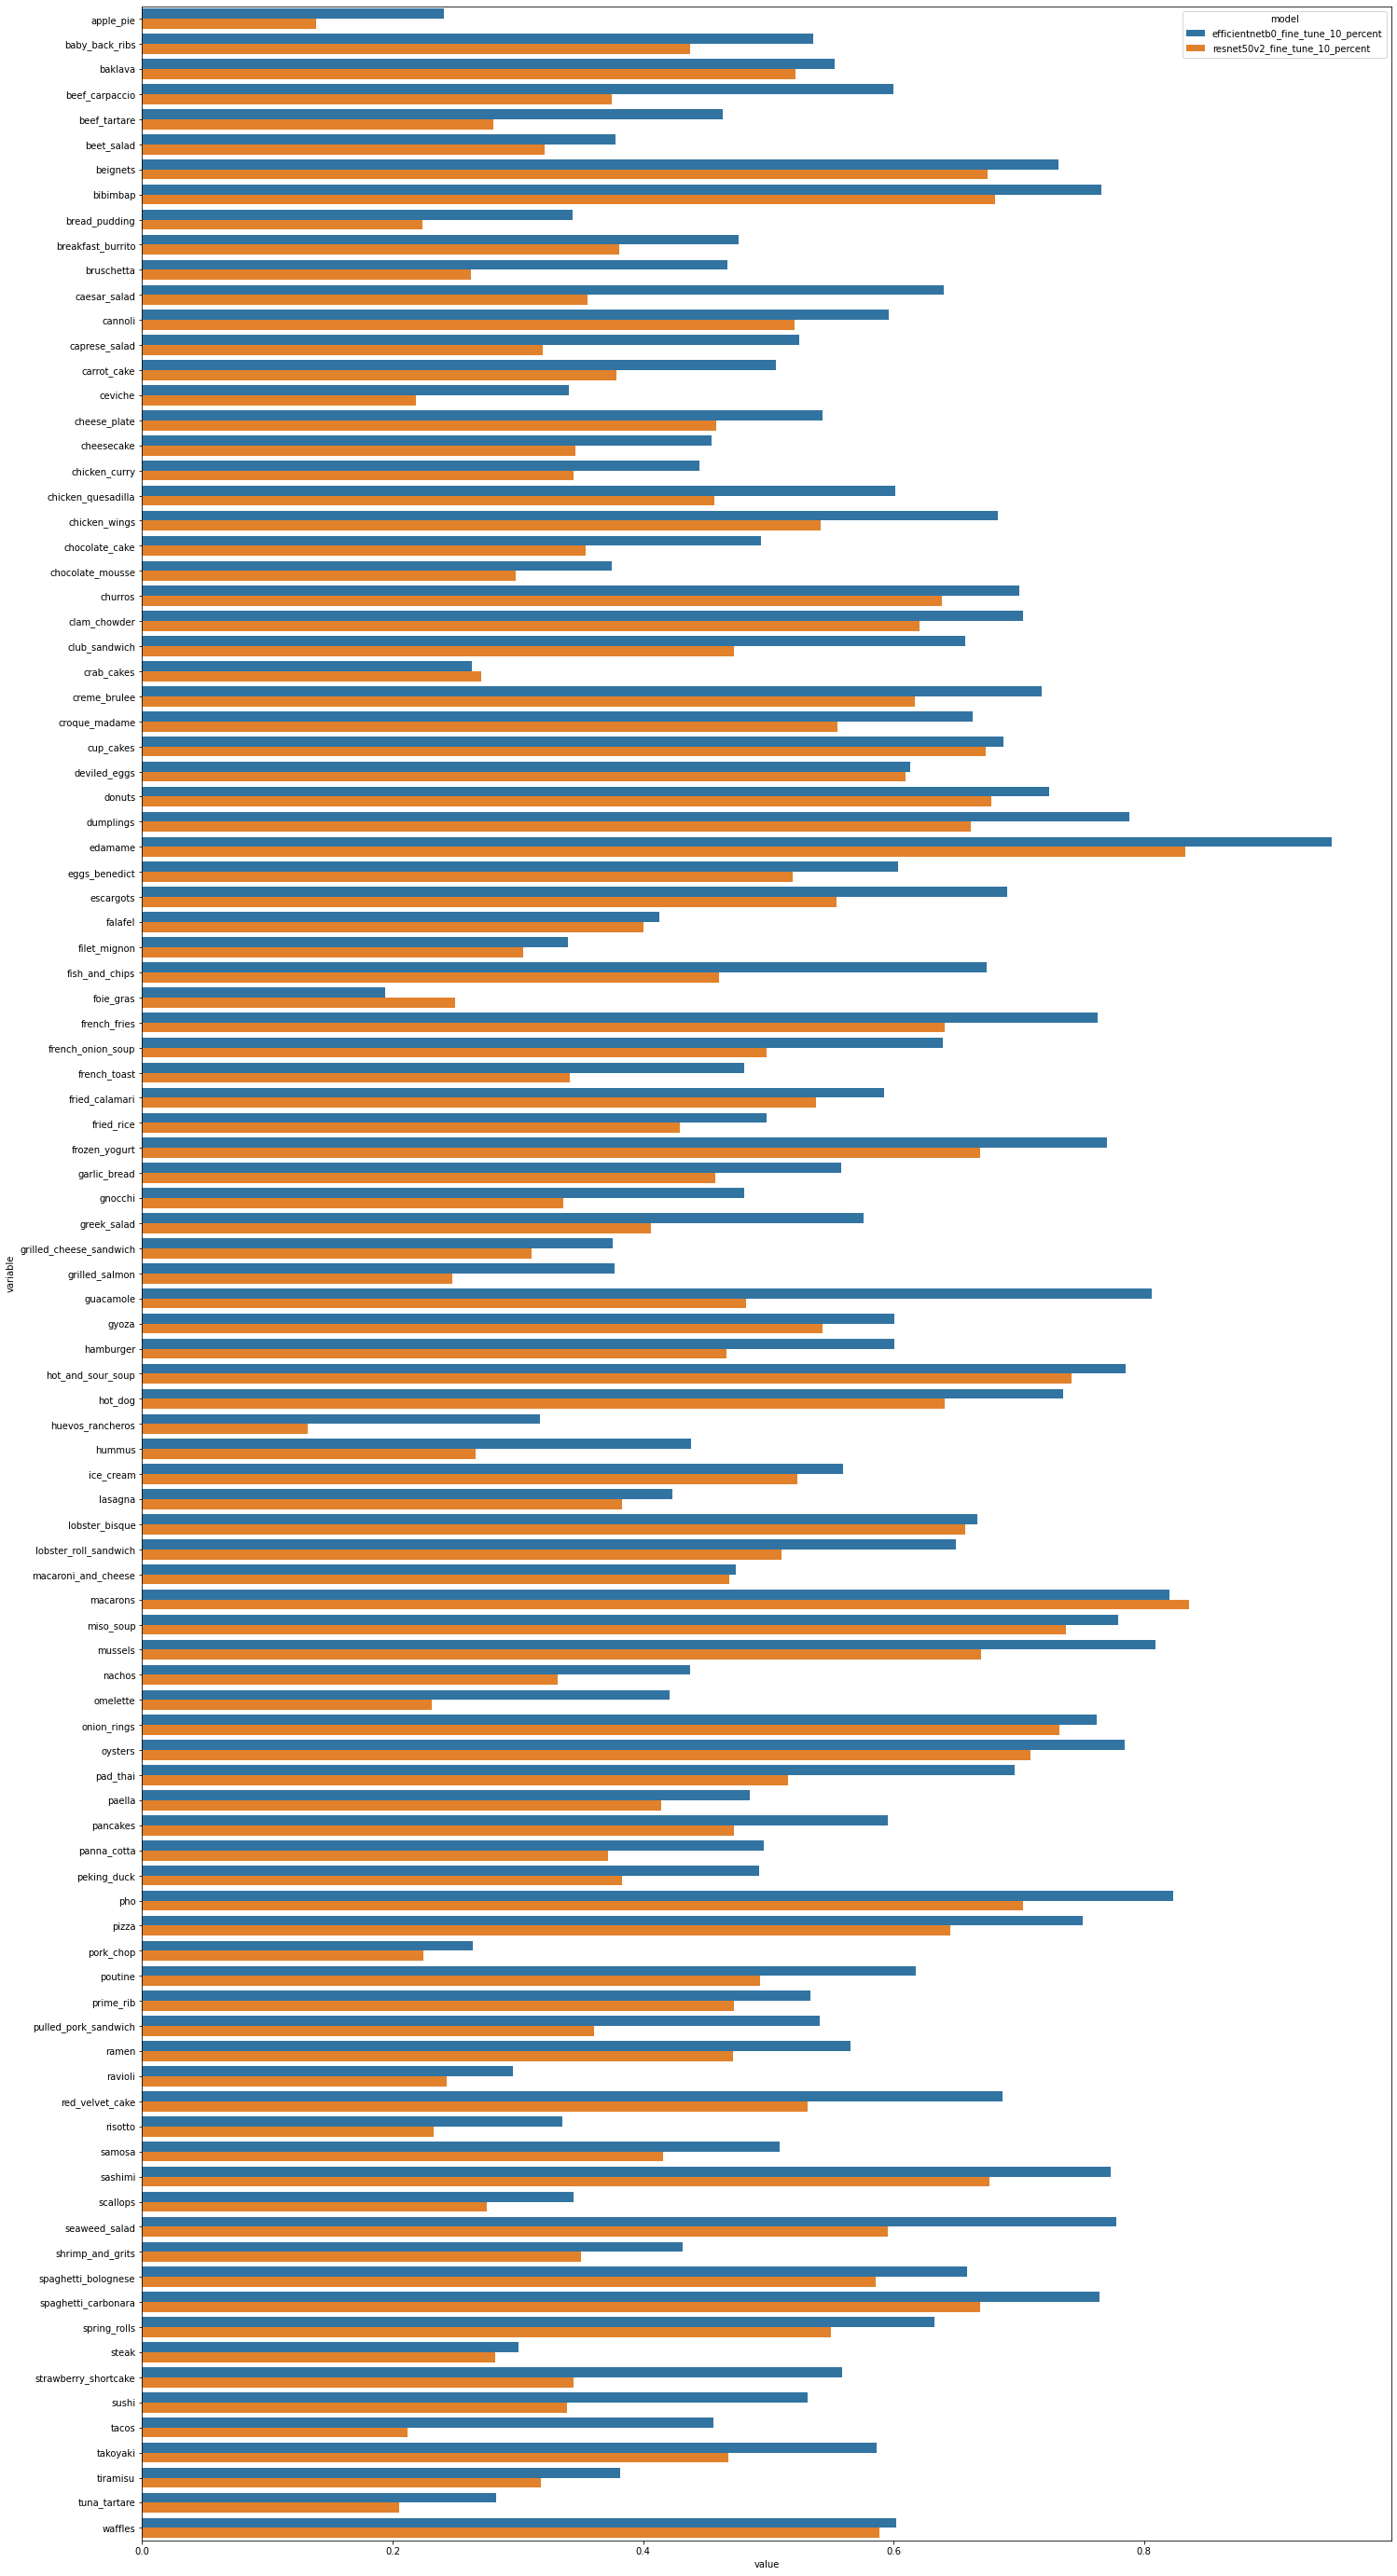

In [211]:
fig, ax = plt.subplots(figsize=(24, 50))
sns.barplot(x='value', y='variable', hue='model', data=compdf_melt.loc[compdf_melt['metric'] == 'f1-score'], orient='h', ax=ax)

Using this plot, we can compare the performance of two models for different classes. Each model performs better on depending on the class label.

### Evaluate predictions of random images

In [212]:
from src.image import ClassicImageDataDirectory

In [247]:
imgdir = ClassicImageDataDirectory(data_dir='../data/101_food_classes_10_percent/', target_image_size=(224, 224), dtype=np.uint8)

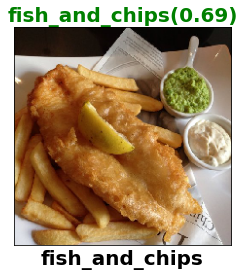

In [260]:
imgdir.view_random_prediction(experiments['efficientnetb0_fine_tune_10_percent'].model, subset='test', datagen=exp.test_datagen);